# Metabolism at a glance - Exercises

Hint: Use page 76 and forward in Villadsen et al
An average biomass elemental composition of CH1.8O0.5N0.2 may be used

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import scipy.optimize as opt
import numpy

## Batch data analysis

A yeast strain was cultivated in batch culture under anaerobic conditions and samples were analyzed for the dry weight, glucose, ethanol and glycerol concentrations.

Let's read the file using pandas.

In [16]:
batch_data = pd.read_csv("data/batch-data-analysis-data.csv")
batch_data

,time [h],biomass [DW g/l],glucose [g/l],ethanol [g/l],glycerol [g/l]
0,0.00,0.0068,NaN,NaN,NaN
1,0.50,0.0100,20.02,0.00,0.01
2,2.42,0.0150,20.09,0.02,0.02
3,4.50,0.0190,20.00,0.03,0.02
4,6.34,0.0286,19.68,0.04,0.05
5,9.25,0.0608,19.47,0.17,0.15
6,11.34,0.1100,19.21,0.31,0.32
7,14.17,0.2300,18.12,0.68,0.36
8,17.17,0.4920,15.47,1.55,0.73
9,17.84,0.5560,14.34,1.96,0.82


### a)

Plot the data, find the region with the exponential growth and find $μ_{max}$.
Hints: you could use [https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html]() for example to fit a function to the data. You will have to define a Python function for that purpose (either using `def` or `lambda`). You can take a look at [https://data-science-for-biotech.github.io/python-novice-inflammation/08-func/index.html]() in case you have never defined a Python function before. If this is too tough, you could resort to Excel to determine $mu_{max}$ or estimate it by eye (using a logarithmic plot).

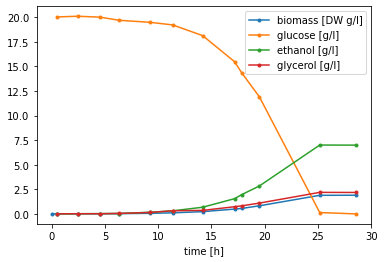

In [17]:
batch_data.plot(x='time [h]', style='.-');

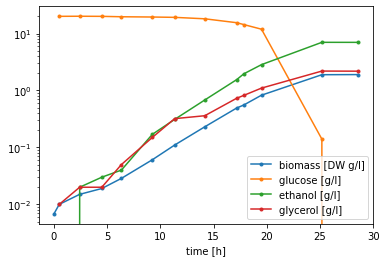

In [18]:
batch_data.plot(x='time [h]', logy=True, style='.-');

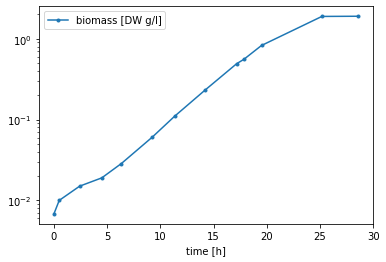

In [19]:
batch_data.plot(x='time [h]', y='biomass [DW g/l]', logy=True, style='.-');

# Totalt inspireret af https://svitla.com/blog/approximation-data-by-exponential-function-on-python
# x = numpy.array(batch_data.loc[:,'time [h]'])
# y = numpy.array(batch_data.loc[:,'biomass [DW g/l]'])
# [a, b], res1 = opt.curve_fit(lambda x1,a,b: a*numpy.exp(b*x1),  x,  y)
# y1 = a * numpy.exp(b * x)


In [6]:
func = lambda t, a, mu_max: a*numpy.exp(mu_max*t)

exp_time_points = batch_data.loc[4:10, 'time [h]']
exp_phase_biomass = batch_data.loc[4:10, 'biomass [DW g/l]']

popt, pcov = opt.curve_fit(func, exp_time_points, exp_phase_biomass)

print('a (intercept) = ' + str(popt[0]) + ' and µ_max = ' + str(popt[1]))
intercept, mu_max = popt

a (intercept) = 0.007604862202582235 and µ_max = 0.24078499428331376


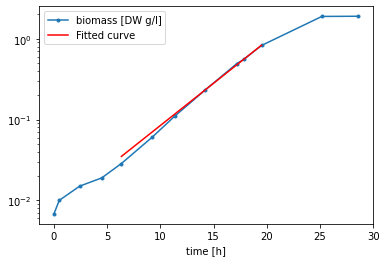

In [7]:
fig, ax = plt.subplots()
batch_data.plot(x='time [h]', y='biomass [DW g/l]', logy=True, ax=ax, style='.-')
ax.plot(exp_time_points, func(exp_time_points, *popt), 'r-', label='Fitted curve')
ax.legend();

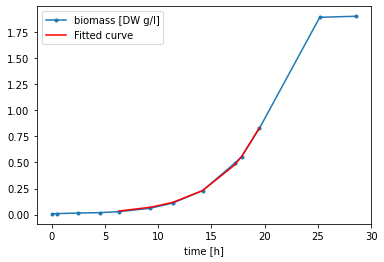

In [8]:
fig, ax = plt.subplots()
batch_data.plot(x='time [h]', y='biomass [DW g/l]', ax=ax, style='.-')
ax.plot(exp_time_points, func(exp_time_points, *popt), 'r-', label='Fitted curve')
ax.legend();

### b) 

During exponential growth the yield coefficients should be constant. Prove it by plotting. Calculate the yield coefficients for biomass, ethanol and glycerol on glucose (Ysx, Yse, and Ysg) in g/g and in Cmol/Cmol.
Assume the generalized composition of the biomass: $CH_{1.8}O_{0.5}N_{0.2}$.

Yield: product against glucose

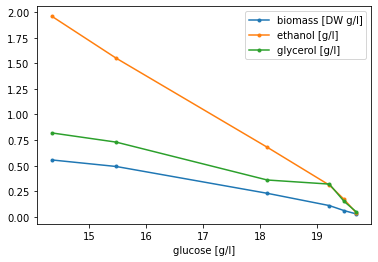

In [9]:
batch_data.iloc[4:10, 1:].plot(x='glucose [g/l]', style='.-');

The plots of product concentrations are linear in the exponential growth phase, proving that the yield coefficients are constant.

Linear models to obtain the slopes (i.e. yield coefficients) using scikit-learn:

In [10]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

biomass [DW g/l] 2.0063513326697957 * y -0.09935749361199336; r2 = 0.9901882229397242; MSE = 0.00042015578542678916
ethanol [g/l] 6.957147291815009 * y -0.34841362076291327; r2 = 0.9976523894280985; MSE = 0.0012269199751399817
glycerol [g/l] 2.756361309924546 * y -0.1327327863350012; r2 = 0.9495606098019909; MSE = 0.0040195990705296815


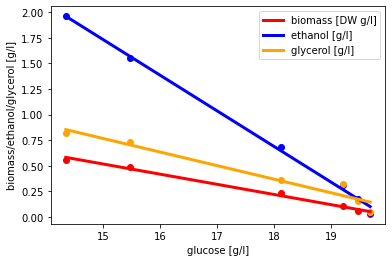

In [11]:
df = batch_data[4:10] # only data during exponential phase

yields = dict() # store yields in dictionary
colors = ('red', 'blue', 'orange') # colors for the plot
for i, var in enumerate(['biomass [DW g/l]', 'ethanol [g/l]', 'glycerol [g/l]']):
    reg = linear_model.LinearRegression() 
    reg.fit(df[['glucose [g/l]']], df[var]) # linear regression fit glucose to different products (saved in var)
    predicted = reg.predict(df[['glucose [g/l]']]) # predict using linear fit
    slope = reg.coef_[0] # gives coefficient of linear fit
    intercept = reg.intercept_ # intercept of linear fit
    yields[var.split(" ")[0]] = -1 * slope # store the result (only name of compound, removing units)
    r2 = r2_score(df[var], predicted) # r-squared
    mse = mean_squared_error(df[var], predicted) # mean squared error
    print(var, f'{intercept} * y {slope}; r2 = {r2}; MSE = {mse}')
    # plot the fitted lines
    plt.scatter(df[['glucose [g/l]']], df[var],  color=colors[i]) # plots the dots
    plt.plot(df['glucose [g/l]'], predicted, color=colors[i], linewidth=3, label=var) # plots the plot
    plt.legend()
    plt.xlabel('glucose [g/l]')
    plt.ylabel('biomass/ethanol/glycerol [g/l]')

In [12]:
yields

{'biomass': 0.09935749361199336,
 'ethanol': 0.34841362076291327,
 'glycerol': 0.1327327863350012}

Yields:
Biomass: 0.099 g DW/g glucose
Ethanol: 0.348 g DW/g glucose
Glycerol: 0.133 g DW/g glucose

In [13]:
# Cmol calculations
yields_cmol = dict()
glu_cmol = 180/6
x_cmol = (1*12 + 1.8*1 + 0.5*16 + 0.2*14) / 1
e_cmol = 46 / 2
g_cmol = 92 / 3
yields_cmol['biomass'] = yields['biomass']*(glu_cmol/x_cmol)
yields_cmol['ethanol'] = yields['ethanol']*(glu_cmol/e_cmol)
yields_cmol['glycerol'] = yields['glycerol']*(glu_cmol/g_cmol)

yields_cmol

{'biomass': 0.12116767513657727,
 'ethanol': 0.45445254882119124,
 'glycerol': 0.1298472909798925}

### c)

Make a C balance and calculate the yield of CO2 on glucose ($Y_{sc}$).

Glucose is the only carbon source, so yields should add up to 1 -> leftover will be CO2.

In [21]:
CO2 = 1 - yields_cmol['biomass'] - yields_cmol['ethanol'] - yields_cmol['glycerol']
CO2

0.29453248506233903

CO2: 0.295 Cmol(CO2) / Cmol(Glu)

### d)

Using the calculated μmax and yield coefficients, calculate the specific consumption rate for glucose ($r_s$) and specific production rates for ethanol, glycerol and CO2 ($r_e$, $r_g$, and $r_c$). Use units of C-mmol/g DW·h.

* $r_s = Y_{xs} \mu_{max} = Y_{sx}^{-1} \mu_{max}$
* $r_e = Y_{se} r_s$
* $r_g = Y_{sg} r_s$
* $r_c = Y_{sc} r_s$

In [ ]:
# Glucose R_s

